In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
from sklearn.datasets import load_sample_image

china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255
images = np.array([china, flower])

In [3]:
def plot_image(image):
    plt.imshow(image, cmap='gray', interpolation='nearest')
    plt.axis('off')
    
def plot_color_image(image):
    plt.imshow(image, interpolation='nearest')
    plt.axis('off')

In [4]:
model = keras.applications.resnet50.ResNet50(weights='imagenet')

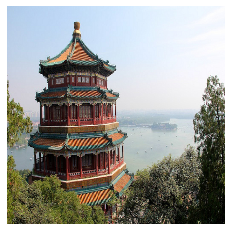

In [5]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


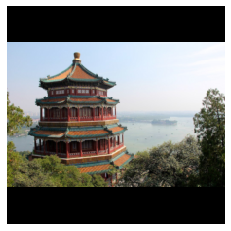

In [6]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])
plt.show()

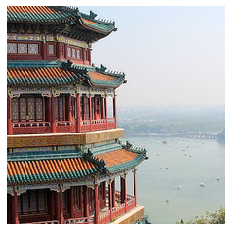

In [7]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

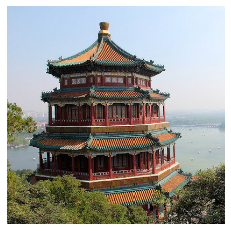

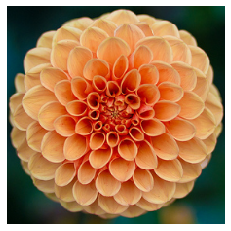

In [8]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [9]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
y_proba = model.predict(inputs)
y_proba.shape

(2, 1000)

In [10]:
top_k = keras.applications.resnet50.decode_predictions(y_proba, top=3)

for image_index in range(len(images)):
    print(f'Image #{image_index}')
    for class_id, name, y_proba in top_k[image_index]:
        print(f'  {class_id} - {name:12s} {y_proba * 100:.2f}%')
    print()

Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.08%
  n03781244 - monastery    11.69%

Image #1
  n04522168 - vase         53.97%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.96%



In [11]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('tf_flowers', as_supervised=True, with_info=True)

In [12]:
info.splits

{'train': <SplitInfo num_examples=3670, num_shards=2>}

In [13]:
info.splits['train']

<SplitInfo num_examples=3670, num_shards=2>

In [14]:
class_names = info.features['label'].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [15]:
n_classes = info.features['label'].num_classes
n_classes

5

In [16]:
dataset_size = info.splits['train'].num_examples
dataset_size

3670

In [17]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    'tf_flowers',
    split=['train[:10%]', 'train[10%:25%]', 'train[25%:]'],
    as_supervised=True)

In [18]:
len(train_set_raw), len(valid_set_raw), len(test_set_raw)

(2752, 551, 367)

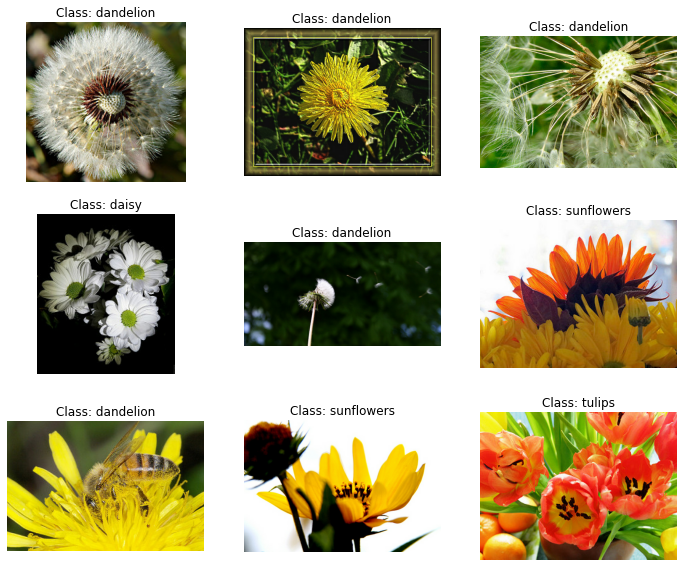

In [19]:
plt.figure(figsize=(12, 10))
index = 0

for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f'Class: {class_names[label]}')
    plt.axis('off')
    
plt.show()

In [20]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [21]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label    

In [22]:
from functools import partial

batch_size = 32
train_set = train_set_raw.shuffle(1000)
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

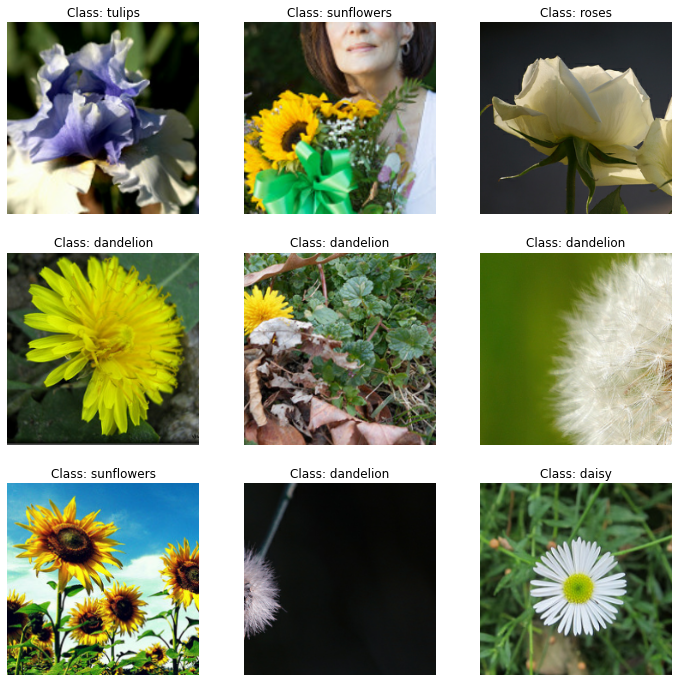

In [23]:
plt.figure(figsize=(12, 12))
for x_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(x_batch[index] / 2 + 0.5)
        plt.title(f'Class: {class_names[y_batch[index]]}')
        plt.axis('off')

plt.show()

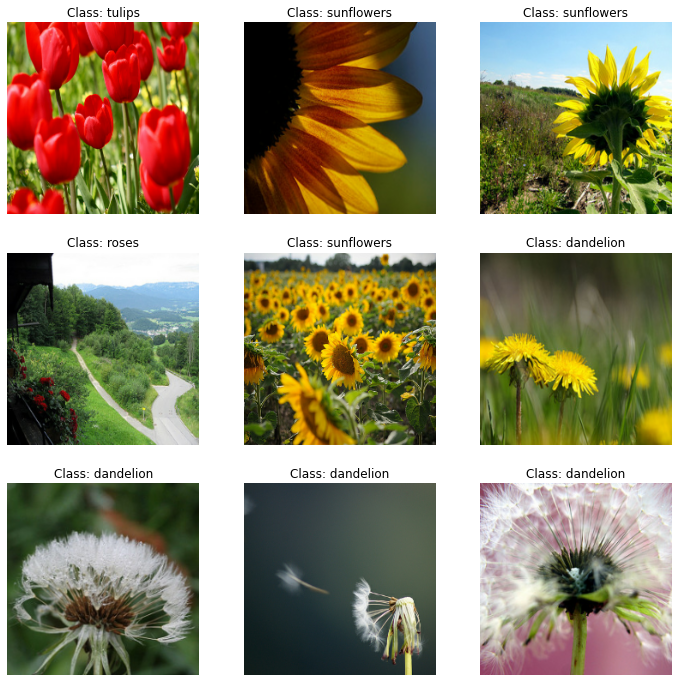

In [24]:
plt.figure(figsize=(12, 12))
for x_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(x_batch[index] / 2 + 0.5)
        plt.title(f'Class: {class_names[y_batch[index]]}')
        plt.axis('off')

plt.show()

In [25]:
base_model = keras.applications.xception.Xception(weights='imagenet', 
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [26]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [27]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.1)
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['acc'])

history = model.fit(train_set, 
                    steps_per_epoch=int(0.75 * dataset_size / batch_size), 
                    validation_data=valid_set, 
                    validation_steps=int(0.15 * dataset_size / batch_size), 
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 93s 1s/step - loss: 0.9367 - acc: 0.8147 - val_loss: 0.7281 - val_acc: 0.8529
Epoch 2/5
86/86 [==============================] - 89s 1s/step - loss: 0.4233 - acc: 0.8986 - val_loss: 0.6325 - val_acc: 0.8548
Epoch 3/5
86/86 [==============================] - 89s 1s/step - loss: 0.3337 - acc: 0.9102 - val_loss: 0.5862 - val_acc: 0.8640
Epoch 4/5
86/86 [==============================] - 89s 1s/step - loss: 0.2957 - acc: 0.9124 - val_loss: 0.5502 - val_acc: 0.8695
Epoch 5/5
86/86 [==============================] - 89s 1s/step - loss: 0.2491 - acc: 0.9230 - val_loss: 0.5296 - val_acc: 0.8658


In [28]:
for layer in base_model.layers:
    layer.trainable = True
    
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, 
                                 nesterov=True, decay=0.1)
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['acc'])

history = model.fit(train_set, 
                    steps_per_epoch=int(0.75 * dataset_size / batch_size), 
                    validation_data=valid_set, 
                    validation_steps=int(0.15 * dataset_size / batch_size), 
                    epochs=40)

Epoch 1/40
86/86 [==============================] - 454s 5s/step - loss: 0.3403 - acc: 0.8797 - val_loss: 0.4156 - val_acc: 0.8787
Epoch 2/40
86/86 [==============================] - 454s 5s/step - loss: 0.1609 - acc: 0.9426 - val_loss: 0.3275 - val_acc: 0.9044
Epoch 3/40
86/86 [==============================] - 465s 5s/step - loss: 0.1338 - acc: 0.9557 - val_loss: 0.3273 - val_acc: 0.9007
Epoch 4/40
86/86 [==============================] - 488s 6s/step - loss: 0.1238 - acc: 0.9553 - val_loss: 0.3274 - val_acc: 0.9044
Epoch 5/40
86/86 [==============================] - 505s 6s/step - loss: 0.1171 - acc: 0.9629 - val_loss: 0.3234 - val_acc: 0.9044
Epoch 6/40
86/86 [==============================] - 490s 6s/step - loss: 0.1055 - acc: 0.9644 - val_loss: 0.3239 - val_acc: 0.9044
Epoch 7/40
86/86 [==============================] - 498s 6s/step - loss: 0.1074 - acc: 0.9622 - val_loss: 0.3205 - val_acc: 0.9026
Epoch 8/40
86/86 [==============================] - 457s 5s/step - loss: 0.1142 - a

In [29]:
model.evaluate(test_set)

12/12 [==============================] - 11s 924ms/step - loss: 0.2190 - acc: 0.9264


[0.21904423832893372, 0.9264305233955383]